# Amazon Video Game Rating - Classification vs Regression.

We extract data from json files. Description of files and preprocessing described in detail in attached paper.
This notebook explores various models, does preprocessing and looks at dataset analysis. To see Bag of Words models and implementations with preprocessing, please see other attached notebook.

In [1]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import gzip
import json

def parseDataFromURL(fname):
  for l in urlopen(fname):
    yield eval(l)

def parseData(fname):
  for l in open(fname):
    yield eval(l)
    
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)
        
    
print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse255/data/beer/beer_50000.json"
data = list(parse("Downloads/Video_Games_5.json.gz"))
print("done")

Reading data...
done


In [4]:
len(data)

497577

In [5]:
data[11]

{'overall': 1.0,
 'vote': '28',
 'verified': False,
 'reviewTime': '05 15, 2012',
 'reviewerID': 'A1LMJ9W8UX1H5B',
 'asin': '0700026657',
 'reviewerName': 'Rob NY',
 'reviewText': "I've bought and played ALL of the ANNO games since 1602, and spent more hours than I can even count building massive empires with extremely complex trade routes. I was thrilled to see another installment released, but I absolutely will NOT pay for something that limits my hardware changes and installs.\n\nWake up UBI, look at all of your other software title reviews, both here on Amazon and on gaming sites. People are not as stupid as you think, and will simply find a different game to fill their time with and throw their money at if their freedoms are inhibited by your software.\n\nBy adding DRM you've actually promoted the use of piracy instead of reduced it, because those that really do want to play it will find a way.",
 'summary': 'SAY NO TO DRM!!',
 'unixReviewTime': 1337040000}

Introducting a baseline accuracy. Trivial case

In [6]:
##Baseline accuracy by predicting mode of the labelss
(len([d for d in data if d['overall'] == 5]))/len(data)

0.6024374116970841

In [7]:
##seperate into validation training set
random.shuffle(data)
training = data[:487577]
validation = data[487577:]

In [74]:
from collections import defaultdict

# Creating a similarity function.

In [76]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
for d in training:
    user,item = d['reviewerID'], d['asin']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)

In [77]:
itemsPerUser['A1LMJ9W8UX1H5B']

{'0700026657', 'B005TMFXZQ', 'B00657AVMO', 'B00684AGQ0', 'B00KWF38AW'}

In [78]:
import statistics
ratingMean = statistics.mean([d['overall'] for d in training])

In [79]:
ratingMode = statistics.mode([d['overall'] for d in training])

In [80]:
len([d['vote'] for d in training if 'vote' in d and d['vote'] == 0])

0

In [89]:
## implement similarity based model
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['asin']
        if i2 == item: continue
        ratings.append((d['overall']))
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return ((sum(weightedRatings) / sum(similarities)))
    else:
        # User hasn't rated any similar items
        return ratingMode

In [90]:
import math
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [91]:
training[14]

{'overall': 5.0,
 'verified': True,
 'reviewTime': '06 8, 2015',
 'reviewerID': 'A2860P952GFG39',
 'asin': 'B00NP8J2LC',
 'style': {'Format:': ' Video Game'},
 'reviewerName': 'Cougar Gold',
 'reviewText': 'Happy with the gift.',
 'summary': 'Five Stars',
 'unixReviewTime': 1433721600}

In [92]:
predictRating('A3GBULTIVS4LNA', 'B00NAW5UZA')

5

In [8]:
##always predict mode
len([d['overall'] for d in validation if d['overall'] == 5])/len(validation)

0.6006

In [94]:
##accuracy
correct = 0
for entry in validation:
    if entry['overall'] == predictRating(entry['reviewerID'], entry['asin']):
        correct += 1
        
correct/len(validation)

0.5472

In [95]:
sums = []
for d in validation:
    sums.append((d['overall'] - ratingMean) * (d['overall'] - ratingMean))
sums = sum(sums)/len(sums)
print(sums)

1.4143744036022714


In [96]:
sums = []
for d in validation:
    sums.append((d['overall'] - predictRating(d['reviewerID'], d['asin'])) * (d['overall'] - predictRating(d['reviewerID'], d['asin'])))
sums = sum(sums)/len(sums)
print(sums)

1.5362


# User - User based similarity

In [98]:
##trying user user similarity

def predictRating(user,item):
    
    ratings = []
    similarities = []
    for d in reviewsPerItem[item]:
        u2 = d['asin']
        if u2 == user: continue
        ratings.append(d['overall'])
        similarities.append(Jaccard(itemsPerUser[user],itemsPerUser[u2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        #print("if")
        return round(sum(weightedRatings) / sum(similarities))
    else:
        # User hasn't rated any similar items
        #print('else')
        return ratingMode

In [99]:
##accuracy

correct = 0
for entry in validation:
    if entry['overall'] == predictRating(entry['reviewerID'], entry['asin']):
        correct += 1
        
correct/len(validation)


0.6044

In [100]:
## implement similarity based model
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['asin']
        if i2 == item: continue
        ratings.append(d['overall'])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        #print('if')
        return round(sum(weightedRatings) / sum(similarities))
    else:
        # User hasn't rated any similar items
        #print('else')
        return ratingMode

In [101]:
correct = 0
for entry in validation:
    if entry['overall'] == predictRating(entry['reviewerID'], entry['asin']):
        correct += 1
        
print(correct/len(validation))


0.5472


# Introducing thresholds / Pipeling

In [111]:
##trying deviation from a threshold
def predictRating(user,item):
    dev = ratingMean
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['asin']
        if i2 == item: continue
        ratings.append(d['overall'] - dev)
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        #print('if')
        #print((sum(weightedRatings) / sum(similarities)))
        returnval= (dev + ((sum(weightedRatings) / sum(similarities)) ))
        return returnval  
    else:
        # User hasn't rated any similar items
        #print('else')
        return ratingMean

In [112]:
correct = 0
for entry in validation:
    if entry['overall'] == predictRating(entry['reviewerID'], entry['asin']):
        correct += 1
        
print(correct/len(validation))



0.266


In [113]:
##MSE
sums = []
for d in validation:
    sums.append((d['overall'] - predictRating(d['reviewerID'], d['asin'])) * (d['overall'] - predictRating(d['reviewerID'], d['asin'])))
sums = sum(sums)/len(sums)
print(sums)

1.3749404173699182


In [139]:
##Similarity is not working
def predictRating(user,item):
    dev = ratingMean
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['asin']
        if i2 == item: continue
        ratings.append(d['overall'] - dev)
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0 and len(similarities) > 6):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        #print('if')
        #print((sum(weightedRatings) / sum(similarities)))
        returnval = dev + (((sum(weightedRatings) / sum(similarities)) ))
        return returnval  
    else:
        # User hasn't rated any similar items
        #print('else')
        return ratingMean

In [136]:
correct = 0
for entry in validation:
    if entry['overall'] == predictRating(entry['reviewerID'], entry['asin']):
        correct += 1
        
print(correct/len(validation))

0.1393


In [137]:
##MSE
sums = []
for d in validation:
    sums.append((d['overall'] - predictRating(d['reviewerID'], d['asin'])) * (d['overall'] - predictRating(d['reviewerID'], d['asin'])))
sums = sum(sums)/len(sums)
print(sums)

1.3181344193377496


In [138]:
training[2]

{'overall': 4.0,
 'verified': True,
 'reviewTime': '01 9, 2015',
 'reviewerID': 'A1PL8WEPH9H7N8',
 'asin': 'B00BWBTJ4Y',
 'reviewerName': 'Matthew Opsahl',
 'reviewText': 'It is nice to get different colors so everyone can know whose controller is whose',
 'summary': 'Four Stars',
 'unixReviewTime': 1420761600}

# SVM with simple features

We notice poor accuracy because of the nature of dataset. Points cannot be linearly separable with simple feature
representations

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [10]:
##support vector machine


y_train = []
'''
for d in training:
    newvec = ohe.copy()
    if(int(d['overall']) > 1 ):
        newvec[int(d['overall']) - 2] = 1
    y_train.append(newvec)
'''  
print("okrunning")
y_train = [d['overall'] for d in training]
x_train = [[len(r['reviewText']) if 'reviewText' in r else 0, r['verified'], int(r['vote'].replace(',','')) if 'vote' in r else 0] for r in training ]
SupportVectorClassModel = SVC()
SupportVectorClassModel.fit(x_train[:10000],y_train[:10000])



okrunning


SVC()

In [11]:
y_val = [d['overall'] for d in validation]
x_val = [[len(r['reviewText']) if 'reviewText' in r else 0, r['verified'], int(r['vote'].replace(',','')) if 'vote' in r else 0] for r in validation ]


y_pred = SupportVectorClassModel.predict(x_train[:10000])

In [12]:
accuracy_score(y_val,y_pred)

0.5992

In [ ]:
rbf = svm.SVC(kernel='rbf', gamma=1, C=0.1).fit(x_train, y_train)

In [ ]:
rbf_pred = rbf.predict(x_val[:10000])
rbf_accuracy = accuracy_score(y_val, rbf_pred)
print(rbf_accuracy)

In [162]:
y_val = [d['overall'] for d in validation]

x_val = [[len(r['reviewText']), r['verified']] if 'reviewText' in r else [0, r['verified']] for r in validation ]

y_pred = SupportVectorClassModel.predict(x_val)

In [163]:
accuracy_score(y_val,y_pred)

0.6044

In [195]:
len([d['overall'] for d in validation if d['overall'] == 5])/len(validation)

0.6044

In [204]:
len([d['overall'] for d in training[:10000] if d['overall'] == 5 ])

6027

# Logistic Regression

In [33]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

In [21]:
#ohe = [0, 0, 0, 0]
x_train = []
y_train = []

y_train = [d['overall'] for d in training]
x_train = [[len(r['reviewText']) if 'reviewText' in r else 0, r['verified'], int(r['vote'].replace(',','')) if 'vote' in r else 0] for r in training]

In [22]:
mod = linear_model.LogisticRegression(C=1.0, class_weight = 'balanced', max_iter = 1000, solver='lbfgs')

In [23]:
mod.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [24]:
y_val = [d['overall'] for d in validation]
x_val = x_train = [[len(r['reviewText']) if 'reviewText' in r else 0, r['verified'], int(r['vote'].replace(',','')) if 'vote' in r else 0] for r in validation]

In [26]:
y_pred = mod.predict(x_val)

In [29]:
#Accuracy on the validation set
correct = 0
for i in range(len(validation)):
    if(y_pred[i] == y_val[i]):
        correct += 1
print(correct/len(validation))

0.4814


# RandomForestClassifier

In [53]:
rfc = RandomForestClassifier()

In [54]:
y_train = [d['overall'] for d in training]
x_train = [[len(r['reviewText']) if 'reviewText' in r else 0, r['verified'], int(r['vote'].replace(',','')) if 'vote' in r else 0] for r in training]

In [55]:
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [56]:
y_val = [d['overall'] for d in validation]
x_val = x_train = [[len(r['reviewText']) if 'reviewText' in r else 0, r['verified'], int(r['vote'].replace(',','')) if 'vote' in r else 0] for r in validation]

In [57]:
rfcpred = rfc.predict(x_val)

In [58]:
#Accuracy on the validation set
correct = 0
for i in range(len(validation)):
    if(rfcpred[i] == y_val[i]):
        correct += 1
print(correct/len(validation))

0.595


# Data Set Analysis

In [62]:
import matplotlib.pyplot as plt

In [61]:
x = [len(r['reviewText']) if 'reviewText' in r else 0 for r in data]
y = [r['overall'] for r in data]

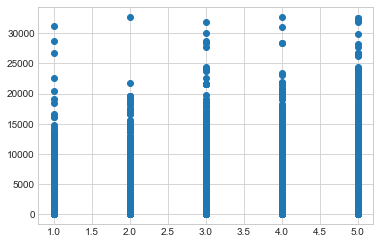

In [64]:
plt.scatter(y, x)
plt.show()

In [67]:
x = [int(r['vote'].replace(',','')) if 'vote' in r else 0 for r in data]
y = [r['overall'] for r in data]

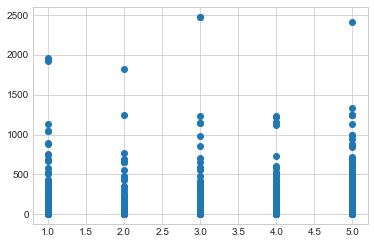

In [68]:
plt.scatter(y, x)
plt.show()

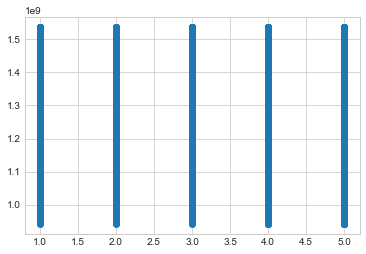

In [70]:
x = [r['unixReviewTime'] for r in data]
y = [r['overall'] for r in data]
plt.scatter(y, x)
plt.show()

# NLP models

In [3]:
from adaptnlp import EasySequenceClassifier

classifier = EasySequenceClassifier()

In [7]:
data[1]

{'overall': 4.0,
 'verified': False,
 'reviewTime': '07 27, 2015',
 'reviewerID': 'A1JGAP0185YJI6',
 'asin': '0700026657',
 'reviewerName': 'travis',
 'reviewText': 'I played it a while but it was alright. The steam was a bit of trouble. The more they move these game to steam the more of a hard time I have activating and playing a game. But in spite of that it was fun, I liked it. Now I am looking forward to anno 2205 I really want to play my way to the moon.',
 'summary': 'But in spite of that it was fun, I liked it',
 'unixReviewTime': 1437955200}

In [1]:
import pandas as pd

In [7]:
df = pd.read_json(r"Downloads/Video_Games_5.json", lines = True)


In [8]:
df = df.drop('image', axis = 1)
df = df.drop('style', axis = 1)
df = df.drop('vote', axis = 1)
df = df.drop('unixReviewTime', axis = 1)
df = df.drop('summary', axis = 1)
df = df.drop('reviewTime', axis = 1)
df = df.drop('verified', axis = 1)

In [9]:
df

,overall,reviewerID,asin,reviewerName,reviewText
0,5,A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu..."
1,4,A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...
2,3,A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.
3,2,A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what..."
4,5,A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since..."
...,...,...,...,...,...
497572,4,AVECM71LSZLC5,B01HGPUTCA,boris teplitskiy,not OEM but good replacement parts
497573,3,A1RS06313BL6WN,B01HH6JEOC,Tom Stopsign,Okay stuff.
497574,3,ACIZ77IGIX2JL,B01HH6JEOC,Era,This does add some kids room things that are v...
497575,4,A34GG58TJ1A3SH,B01HIZF7XE,seamonkey10,I think I originally began playing Bioshock se...


In [10]:
df = df.dropna(axis = 0)

In [11]:
df

,overall,reviewerID,asin,reviewerName,reviewText
0,5,A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu..."
1,4,A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...
2,3,A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.
3,2,A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what..."
4,5,A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since..."
...,...,...,...,...,...
497572,4,AVECM71LSZLC5,B01HGPUTCA,boris teplitskiy,not OEM but good replacement parts
497573,3,A1RS06313BL6WN,B01HH6JEOC,Tom Stopsign,Okay stuff.
497574,3,ACIZ77IGIX2JL,B01HH6JEOC,Era,This does add some kids room things that are v...
497575,4,A34GG58TJ1A3SH,B01HIZF7XE,seamonkey10,I think I originally began playing Bioshock se...


In [12]:
df.to_csv (r"Downloads/Video_Games_5csv.csv", index = None)

In [15]:
from transformers import TrainingArguments

 
training_args = TrainingArguments(

output_dir='./models',

num_train_epochs=1,

per_device_train_batch_size=16,

per_device_eval_batch_size=16,

warmup_steps=500,

weight_decay=0.01,

evaluate_during_training=True,

logging_dir='./logs',

save_steps=100

)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/transformers/training_args.py:347: FutureWarning: The `evaluate_during_training` argument is deprecated in favor of `evaluation_strategy` (which has more options)
  FutureWarning,


In [16]:
from datasets import load_dataset

train_dataset, eval_dataset = load_dataset('ag_news', split=['train[:10%]', 'test'])

Using custom data configuration default


Dataset ag_news downloaded and prepared to /Users/sri/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a. Subsequent calls will reuse this data.


In [19]:
classifier.train(

training_args=training_args,

train_dataset='Downloads/Video_Games_5csv.csv',

eval_dataset='Downloads/Video_Games_5csv.csv',

model_name_or_path="bert-base-cased",

text_col_nm="reviewText",

label_col_nm="overall",

)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

ValueError: Must pass in `label_names` parameter for training when loading in CSV datasets.

In [13]:
import pandas as pd

#data_path = "data/" 
data_file_address = 'Downloads/Video_Games_5csv.csv'

df_data = pd.read_csv(data_file_address,sep=",",encoding="utf-8",names=['overall','reviewText'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
# Have a look at the dataset
df_data.head(n=20)

# Have a look labels 
df_data.overall.unique()

# Analyse the labels distribution
df_data.overall.value_counts()

{'Format:': ' Video Game'}                                       129039
{'Platform:': ' PlayStation 3'}                                   10656
{'Platform:': ' Xbox 360'}                                        10639
{'Edition:': ' Standard', 'Platform:': ' PlayStation 4'}           9219
{'Platform:': ' PC'}                                               8424
                                                                  ...  
{'Color:': ' Red Mechanical Switch', 'Style:': ' Excalibur'}          1
{'Size:': ' Laser', 'Style:': ' GMS7011'}                             1
{'Color:': ' Black & White'}                                          1
{'Color:': ' Blue Mechanical Switch', 'Style:': ' Excalibur'}         1
{'Color:': ' Forza 2'}                                                1
Name: overall, Length: 2324, dtype: int64

# XLNet

In [25]:
import pandas as pd


train_df = pd.read_csv('Downloads/Video_Games_5csv.csv', header=None)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
train_df

,0,1,2,3,4
0,overall,reviewerID,asin,reviewerName,reviewText
1,5,A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu..."
2,4,A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...
3,3,A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.
4,2,A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what..."
...,...,...,...,...,...
497339,4,AVECM71LSZLC5,B01HGPUTCA,boris teplitskiy,not OEM but good replacement parts
497340,3,A1RS06313BL6WN,B01HH6JEOC,Tom Stopsign,Okay stuff.
497341,3,ACIZ77IGIX2JL,B01HH6JEOC,Era,This does add some kids room things that are v...
497342,4,A34GG58TJ1A3SH,B01HIZF7XE,seamonkey10,I think I originally began playing Bioshock se...


In [18]:
train_df['text'] = train_df.iloc[:, 4]
train_df['label'] = train_df.iloc[:, 0]
train_df = train_df.drop(train_df.columns[[0,1, 2, 3, 4]], axis=1)
#train_df = train_df.drop(train_df.rows[[0]], axis=1)

In [19]:
train_df

,text,label
0,reviewText,overall
1,"This game is a bit hard to get the hang of, bu...",5
2,I played it a while but it was alright. The st...,4
3,ok game.,3
4,"found the game a bit too complicated, not what...",2
...,...,...
497339,not OEM but good replacement parts,4
497340,Okay stuff.,3
497341,This does add some kids room things that are v...,3
497342,I think I originally began playing Bioshock se...,4


In [20]:
train_df.columns = ['text', 'label']
train_df = train_df[['text', 'label']]
#train_df['text'] = train_df['text'].apply(lambda x: x.replace('\\', ' '))
#train_df['label'] = train_df['label'].apply(lambda x:str(x)-1)

In [21]:
train_df

,text,label
0,reviewText,overall
1,"This game is a bit hard to get the hang of, bu...",5
2,I played it a while but it was alright. The st...,4
3,ok game.,3
4,"found the game a bit too complicated, not what...",2
...,...,...
497339,not OEM but good replacement parts,4
497340,Okay stuff.,3
497341,This does add some kids room things that are v...,3
497342,I think I originally began playing Bioshock se...,4


In [27]:
eval_df = pd.read_csv('Downloads/Video_Games_5csv.csv', header=None)
eval_df.sample(frac=1)
eval_df['text'] = eval_df.iloc[:, 4]
eval_df['label'] = eval_df.iloc[:, 0]
eval_df = eval_df.drop(eval_df.columns[[0,1, 2, 3, 4]], axis=1)
#eval_df.columns = ['text', 'label']
#eval_df = eval_df[['text', 'label']]
#eval_df['text'] = eval_df['text'].apply(lambda x: x.replace('\\', ' '))
#eval_df['label'] = eval_df['label'].apply(lambda x:x-1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
eval_df

,text,label
0,reviewText,overall
1,"This game is a bit hard to get the hang of, bu...",5
2,I played it a while but it was alright. The st...,4
3,ok game.,3
4,"found the game a bit too complicated, not what...",2
...,...,...
497339,not OEM but good replacement parts,4
497340,Okay stuff.,3
497341,This does add some kids room things that are v...,3
497342,I think I originally began playing Bioshock se...,4


In [29]:
eval_df = eval_df.iloc[1:]

In [30]:
eval_df  = eval_df.dropna(axis = 0)


In [31]:
eval_df

,text,label
1,"This game is a bit hard to get the hang of, bu...",5
2,I played it a while but it was alright. The st...,4
3,ok game.,3
4,"found the game a bit too complicated, not what...",2
5,"great game, I love it and have played it since...",5
...,...,...
497339,not OEM but good replacement parts,4
497340,Okay stuff.,3
497341,This does add some kids room things that are v...,3
497342,I think I originally began playing Bioshock se...,4


In [32]:
eval_df['label'] = eval_df['label'].apply(lambda x:int(x)-1)

In [33]:
eval_df

,text,label
1,"This game is a bit hard to get the hang of, bu...",4
2,I played it a while but it was alright. The st...,3
3,ok game.,2
4,"found the game a bit too complicated, not what...",1
5,"great game, I love it and have played it since...",4
...,...,...
497339,not OEM but good replacement parts,3
497340,Okay stuff.,2
497341,This does add some kids room things that are v...,2
497342,I think I originally began playing Bioshock se...,3


In [34]:
train_df = eval_df.iloc[0:5000]

In [35]:
eval_dftrun = eval_df.iloc[5000:6000]

In [36]:
eval_df

,text,label
1,"This game is a bit hard to get the hang of, bu...",4
2,I played it a while but it was alright. The st...,3
3,ok game.,2
4,"found the game a bit too complicated, not what...",1
5,"great game, I love it and have played it since...",4
...,...,...
497339,not OEM but good replacement parts,3
497340,Okay stuff.,2
497341,This does add some kids room things that are v...,2
497342,I think I originally began playing Bioshock se...,3


In [31]:
from simpletransformers.classification import ClassificationModel


# Create a ClassificationModel
model = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=5, use_cuda = False)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [44]:
# Train the model
model.train_model(train_df)

RuntimeError: [enforce fail at inline_container.cc:262] . unexpected pos 40165248 vs 40165136

In [46]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, f1=f1_multiclass, acc=accuracy_score)

In [47]:
result

{'mcc': 0.4135980245877873,
 'f1': 0.702,
 'acc': 0.702,
 'eval_loss': 0.812588570177555}

In [48]:
eval_dftrun = eval_df.iloc[10000:11000]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)

In [49]:
result

{'mcc': 0.37617129324863885, 'acc': 0.701, 'eval_loss': 0.7840018681287766}

In [50]:
eval_dftrun = eval_df.iloc[50342:51342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.34645608362786556, 'acc': 0.627, 'eval_loss': 0.9404988695979118}


In [51]:
eval_dftrun = eval_df.iloc[150342:151342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.3863914074686631, 'acc': 0.612, 'eval_loss': 1.0088129776716233}


In [52]:
eval_dftrun = eval_df.iloc[450342:451342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.4407023503427808, 'acc': 0.699, 'eval_loss': 0.8224271050393581}


In [54]:
eval_dftrun = eval_df.iloc[407342:408342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.40647336215227653, 'acc': 0.672, 'eval_loss': 0.8827728629112244}


In [55]:
eval_dftrun = eval_df.iloc[357342:358342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.4194099116404517, 'acc': 0.768, 'eval_loss': 0.6840691976249218}


In [56]:
eval_dftrun = eval_df.iloc[302342:303342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.4654181751498634, 'acc': 0.705, 'eval_loss': 0.7940712544620037}


In [57]:
eval_dftrun = eval_df.iloc[251342:252342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.3852043008839199, 'acc': 0.637, 'eval_loss': 0.9609800043702126}


In [58]:
eval_dftrun = eval_df.iloc[208342:209342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.38833618255218894, 'acc': 0.631, 'eval_loss': 0.9111251401901245}


In [60]:
eval_dftrun = eval_df.iloc[102342:103342]
result, model_outputs, wrong_predictions = model.eval_model(eval_dftrun, acc=accuracy_score)
print(result)


{'mcc': 0.33487395787781377, 'acc': 0.605, 'eval_loss': 1.036223285496235}


# BERT pretrained model

In [37]:
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('bert', 'bert-base-cased', num_labels=5, args={'reprocess_input_data': True, 'overwrite_output_dir': True}, use_cuda = False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
model.train_model(train_df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [3]:
##Finding the baseline accuracies
len([d for d in data[5000:6000] if d['overall'] == 5])/1000

0.63

In [4]:
len([d for d in data[10000:11000] if d['overall'] == 5])/1000

0.651

In [5]:
len([d for d in data[50342:51342] if d['overall'] == 5])/1000

0.558

In [6]:
len([d for d in data[150342:151342] if d['overall'] == 5])/1000

0.508

In [7]:
len([d for d in data[450342:451342] if d['overall'] == 5])/1000

0.632

In [8]:
len([d for d in data[407342:408342] if d['overall'] == 5])/1000

0.628

In [9]:
len([d for d in data[357342:358342] if d['overall'] == 5])/1000

0.721

In [10]:
len([d for d in data[302342:303342] if d['overall'] == 5])/1000

0.608

In [11]:
len([d for d in data[251342:252342] if d['overall'] == 5])/1000

0.558

In [12]:
len([d for d in data[208342:209342] if d['overall'] == 5])/1000

0.532

In [13]:
len([d for d in data[102342:103342] if d['overall'] == 5])/1000

0.533

In [ ]:
len([d for d in data[102342:103342] if d['overall'] == 5])/1000

# Comparing different models

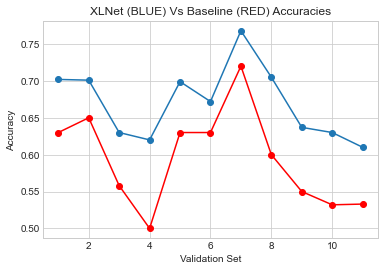

In [19]:
import matplotlib.pyplot as plt
   
iteration = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
XLNet = [0.702, 0.701, 0.63, 0.62, 0.699, 0.672, 0.768, 0.705, 0.637, 0.63, 0.61]
baseline = [0.63, 0.65, 0.558, 0.5, 0.63, 0.63, 0.72, 0.6, 0.55, 0.532, 0.533]
  
plt.plot(iteration, XLNet, marker = 'o')
plt.plot(iteration, baseline, color = 'red', marker = 'o')
plt.title('XLNet (BLUE) Vs Baseline (RED) Accuracies')
plt.xlabel('Validation Set')
plt.ylabel('Accuracy')
plt.show()

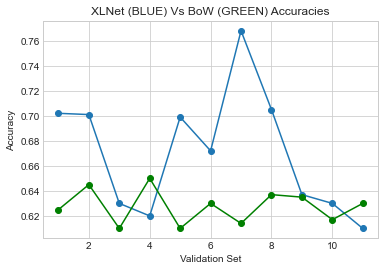

In [25]:
import matplotlib.pyplot as plt
   
iteration = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
XLNet = [0.702, 0.701, 0.63, 0.62, 0.699, 0.672, 0.768, 0.705, 0.637, 0.63, 0.61]
baseline = [0.63, 0.65, 0.558, 0.5, 0.63, 0.63, 0.72, 0.6, 0.55, 0.532, 0.533]
BoW = [0.625, 0.645, 0.61, 0.65, 0.61, 0.63, 0.614, 0.637, 0.635, 0.617, 0.63]
  
plt.plot(iteration, XLNet, marker = 'o')
plt.plot(iteration, BoW, color = 'green', marker = 'o')
plt.title('XLNet (BLUE) Vs BoW (GREEN) Accuracies')
plt.xlabel('Validation Set')
plt.ylabel('Accuracy')
plt.show()

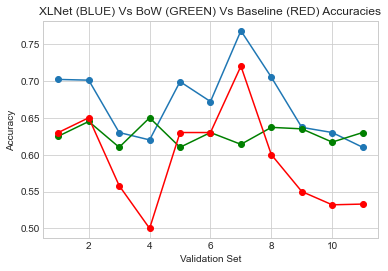

In [26]:
import matplotlib.pyplot as plt
   
iteration = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
XLNet = [0.702, 0.701, 0.63, 0.62, 0.699, 0.672, 0.768, 0.705, 0.637, 0.63, 0.61]
baseline = [0.63, 0.65, 0.558, 0.5, 0.63, 0.63, 0.72, 0.6, 0.55, 0.532, 0.533]
BoW = [0.625, 0.645, 0.61, 0.65, 0.61, 0.63, 0.614, 0.637, 0.635, 0.617, 0.63]
  
plt.plot(iteration, XLNet, marker = 'o')
plt.plot(iteration, BoW, color = 'green', marker = 'o')
plt.plot(iteration, baseline, color = 'red', marker = 'o')
plt.title('XLNet (BLUE) Vs BoW (GREEN) Vs Baseline (RED) Accuracies')
plt.xlabel('Validation Set')
plt.ylabel('Accuracy')
plt.show()

In [32]:
import statistics
#statistics.mean(XLNet)
statistics.mean(baseline)

0.5939090909090909